In [1]:
import cv2
import mediapipe as mp
import time
import math
import matplotlib.pyplot as plt

# Initialize MediaPipe hands module
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

# Initialize MediaPipe face module for facial landmarks (for lips and eyebrows)
mp_face = mp.solutions.face_mesh
face_mesh = mp_face.FaceMesh()


# Note!!!
## I took the initiative on defining stress from my own logic. There is no scientific background behind the exact values. The only thing confirmed right about the values is that they are correlated with shown stress.

In [2]:
# Placeholder logic for calculating stress from hand landmarks
def calculate_hand_stress(results_hands):
    if results_hands.multi_hand_landmarks:
        hand_landmarks = results_hands.multi_hand_landmarks[0]  # Assuming there's only one hand
        # Calculate the average distance between fingers as a simple stress indicator
        finger_distances = calculate_average_finger_distances(hand_landmarks)
        # Sum of distances normalized between 0 and 1
        stress = sum(finger_distances) / len(finger_distances)
        return stress
    else:
        return 0.0

# Placeholder logic for calculating stress from lip landmarks
def calculate_lips_stress(results_face):
    if results_face.multi_face_landmarks:
        face_landmarks = results_face.multi_face_landmarks[0]  # Assuming there's only one face
        # Calculate the ratio of lip width to lip height as a simple stress indicator
        lip_ratio = calculate_lip_ratio(face_landmarks)
        # Invert the ratio, assuming higher ratio means more stress
        stress = 1.0 / lip_ratio
        return stress
    else:
        return 0.0

# Placeholder logic for calculating stress from eyebrow landmarks
def calculate_eyebrows_stress(results_face):
    if results_face.multi_face_landmarks:
        face_landmarks = results_face.multi_face_landmarks[0]  # Assuming there's only one face
        # Calculate the average height of eyebrows as a simple stress indicator
        eyebrow_heights = calculate_average_eyebrow_heights(face_landmarks)
        # Sum of heights normalized between 0 and 1
        stress = sum(eyebrow_heights)
        return stress
    else:
        return 0.0


In [3]:
# Helper function to calculate average distances between finger landmarks
def calculate_average_finger_distances(hand_landmarks):
    finger_distances = []
    for finger in range(5):  # Assuming there are 5 fingers
        for i in range(4):  # 4 segments in each finger
            idx1 = i + finger * 4
            idx2 = (i + 1) + finger * 4
            distance = calculate_distance(hand_landmarks.landmark[idx1], hand_landmarks.landmark[idx2])
            finger_distances.append(distance)
    return finger_distances

# Helper function to calculate distance between two landmarks
def calculate_distance(landmark1, landmark2):
    x1, y1, z1 = landmark1.x, landmark1.y, landmark1.z
    x2, y2, z2 = landmark2.x, landmark2.y, landmark2.z
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

# Helper function to calculate the ratio of lip width to lip height
def calculate_lip_ratio(face_landmarks):
    lip_width = calculate_distance(face_landmarks.landmark[48], face_landmarks.landmark[54])  # Distance between corners of the mouth
    lip_height = calculate_distance(face_landmarks.landmark[51], face_landmarks.landmark[57])  # Distance between upper and lower lip
    return lip_width / lip_height

# Helper function to calculate average heights of eyebrows
def calculate_average_eyebrow_heights(face_landmarks):
    eyebrow_heights = []
    for eye in range(2):  # Loop through left (eye=0) and right (eye=1) eyebrows
        start_idx = eye * 5  # Starting index for the eyebrow landmarks
        end_idx = start_idx + 5  # Ending index for the eyebrow landmarks
        distances = [
            calculate_distance(face_landmarks.landmark[i], face_landmarks.landmark[i + 5])
            for i in range(start_idx, end_idx)
        ]
        average_distance = sum(distances) / len(distances)
        eyebrow_heights.append(average_distance)
    return eyebrow_heights


In [4]:
# Calculate overall stress using a defined formula
def calculate_overall_stress(stress_hands, stress_lips, stress_eyebrows):
    # Define weights for each component (hand, lips, eyebrows)
    weight_hands = 0.4
    weight_lips = 0.3
    weight_eyebrows = 0.3

    # Calculate the overall stress as a weighted sum
    overall_stress = (
        weight_hands * stress_hands +
        weight_lips * stress_lips +
        weight_eyebrows * stress_eyebrows
    )

    return overall_stress

In [5]:
def display_stress_on_frame(frame, stress_hands, stress_lips, stress_eyebrows, overall_stress):
    # Convert stress levels to text for display
    stress_text = f"Hands: {stress_hands:.2f} | Lips: {stress_lips:.2f} | Eyebrows: {stress_eyebrows:.2f} | Overall: {overall_stress:.2f}"

    # Display the stress text on the frame
    cv2.putText(frame, stress_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

    return frame


# Live stream stress checker

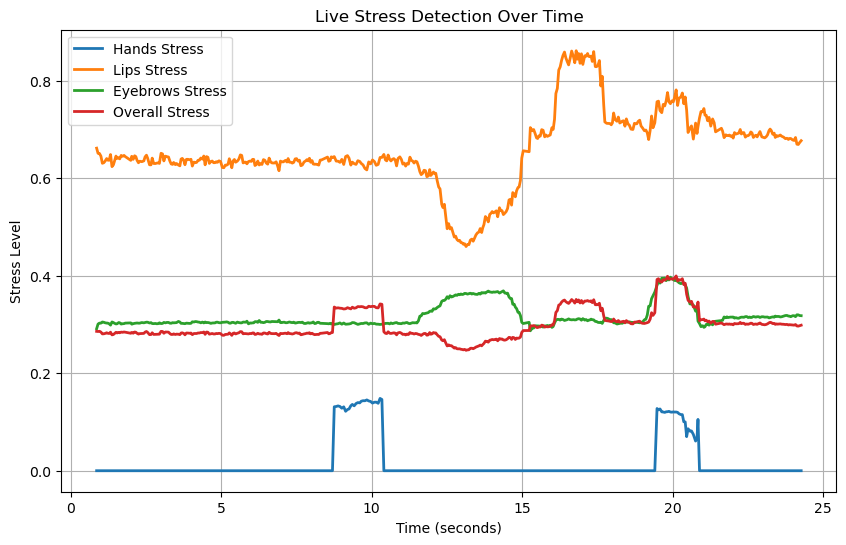

In [10]:
# Create a VideoCapture object for live webcam feed
cap = cv2.VideoCapture(0)  # Use 0 for the default webcam, change if you have multiple webcams

# Set the dimensions of the live camera feed based on the known dimensions of the original video
original_width, original_height = 1080, 720  # Replace with the actual dimensions of your camera

cap.set(3, original_width)  # 3 corresponds to width
cap.set(4, original_height)  # 4 corresponds to height

# Stress level data
stress_data = {"time_points": [], "hands": [], "lips": [], "eyebrows": [], "overall": []}

# Open a window to display the live feed
cv2.namedWindow('Stress Detection', cv2.WINDOW_NORMAL)

start_time = time.time()  # Record the start time

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with MediaPipe hands
    results_hands = hands.process(frame_rgb)

    # Process the frame with MediaPipe face mesh
    results_face = face_mesh.process(frame_rgb)

    # Calculate stress levels for hands, lips, and eyebrows
    stress_hands = calculate_hand_stress(results_hands)
    stress_lips = calculate_lips_stress(results_face)
    stress_eyebrows = calculate_eyebrows_stress(results_face)

    # Calculate overall stress using a defined formula
    overall_stress = calculate_overall_stress(stress_hands, stress_lips, stress_eyebrows)

    # Update stress level data
    elapsed_time = time.time() - start_time  # Calculate elapsed time in seconds
    stress_data["time_points"].append(elapsed_time)
    stress_data["hands"].append(stress_hands)
    stress_data["lips"].append(stress_lips)
    stress_data["eyebrows"].append(stress_eyebrows)
    stress_data["overall"].append(overall_stress)

    # Display the frame with stress levels
    frame = display_stress_on_frame(frame, stress_hands, stress_lips, stress_eyebrows, overall_stress)
    cv2.imshow('Stress Detection', frame)

    # Break the loop on 'q' key press or when the window is closed
    key = cv2.waitKey(1)
    if key == ord('q') or cv2.getWindowProperty('Stress Detection', cv2.WND_PROP_VISIBLE) < 1:
        break

# Release the VideoCapture object
cap.release()

# Close all OpenCV windows
cv2.destroyAllWindows()

# Plot the stress levels over time after the live session
time_points = stress_data["time_points"]
stress_hands = stress_data["hands"]
stress_lips = stress_data["lips"]
stress_eyebrows = stress_data["eyebrows"]
overall_stress = stress_data["overall"]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_points, stress_hands, label='Hands Stress', linewidth=2)
plt.plot(time_points, stress_lips, label='Lips Stress', linewidth=2)
plt.plot(time_points, stress_eyebrows, label='Eyebrows Stress', linewidth=2)
plt.plot(time_points, overall_stress, label='Overall Stress', linewidth=2)
plt.xlabel('Time (seconds)')
plt.ylabel('Stress Level')
plt.title('Live Stress Detection Over Time')
plt.legend()
plt.grid(True)
plt.show()



In the graph I tried to use each feature alone and then all together at the end.
eyebrows (t=8.5s), hands (t=13s), eyebrows (t=17s) and all of them at (t=19s),
Apparently eyebrows stress and lips stress are negatively correlated.
Hands stress are null if they are out of the camera range.

# Non Live stream stress checker